In [1]:
import sys
import pickle
import glob
import os
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
import qubic
from qubic import AnalysisMC as amc
from qubic import QubicSkySim as qss
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two'
# thedir = '/home/nahue-ofi/heavy-data/forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two'

dic_name = '*file*'
realizations = np.sort(glob.glob(thedir + '/' + dic_name))

# for i in range(len(realizations)):
#     print(i, realizations[i])

# realizations = realizations[:30]

In [2]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two'
# thedir = '/home/nahue-ofi/heavy-data/forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two'

# dic_name = 'file*'
# realizations_2 = np.array(np.sort(glob.glob(thedir + '/' + dic_name)))

# for i in range(len(realizations_2)):
#     print(i, realizations_2[i])

In [3]:
# nreals = len(realizations_1)+len(realizations_2)

# r = np.concatenate((realizations_1,realizations_2),axis=0)

# # for i in range(nreals):
# #     realizations[i] = realizations_1[i]
# #     realizations[i+len(realizations_1)] = realizations_2[i]
    
# # print([[realizations_1],[realizations]])
# print(realizations)

In [4]:
# print(realizations_1)
# # print(reals)
# # print(type(realizations))
# # extend(realizations_1)

In [5]:
nreals = len(realizations)

print(nreals)

99


In [6]:
def noise_analysis_qubicpatch(map_file,constant_spectral_index=True,nbins_ring=25):
    
    map_dict = pickle.load(open(map_file,'rb'))
    
    if constant_spectral_index:
        ncomps_out = map_dict['components_i'].shape[0]
        ncomps_in = map_dict['components'].shape[0]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[2]
        comp_in = map_dict['components']
        comp_out = map_dict['components_i']
        residuals = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
    else:
        ncomps_out = map_dict['components_i'].shape[2]
        ncomps_in = map_dict['components'].shape[2]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[0]
        comp_in = map_dict['components'].T
        comp_out = map_dict['components_i'].T
        residuals = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
    
    comp_out_qubicpatch = comp_out[:,map_dict['seenpix'],:]
    comp_in_qubicpatch = comp_in[:,map_dict['seenpix'],:]
    residuals_qubicpatch = residuals[:,map_dict['seenpix'],:]

    center = map_dict['center']
    # center_equ = map_dict['center']#[0,-57]
    # center_gal = qubic.equ2gal(center_equ[0], center_equ[1])
    
    nside = hp.npix2nside(npix_tot)
    pixsnum_seenpix = np.where(seenpix)[0]
    centralpix = hp.ang2pix(nside, center[0],center[1],lonlat=True)
    angmax= np.max( qss.get_angles(centralpix,pixsnum_seenpix,nside) )

    angs_int_dust,I_int_dust,Q_int_dust,U_int_dust,dI_int_dust,dQ_int_dust,dU_int_dust = get_angular_profile(residuals[1,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)
    angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb = get_angular_profile(residuals[0,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)

    residuals_angular_circles = np.array([[angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb],[angs_int_dust,I_int_dust,Q_int_dust,U_int_dust,dI_int_dust,dQ_int_dust,dU_int_dust]])
    
    angs_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust = qss.get_angular_profile(residuals[1,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)
    angs_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb = qss.get_angular_profile(residuals[0,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)

    residuals_angular_rings = np.array([[angs_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb],[angs_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust]])
    
    return comp_out_qubicpatch, comp_in_qubicpatch, residuals_qubicpatch, residuals_angular_circles, residuals_angular_rings, angmax, residuals, seenpix, nside

In [7]:
sys.path.insert(1,"/home/nahue-ofi/CMM-Pipeline/src")

from simtools.analysis import get_angular_profile

In [8]:
constant_spectral_index = True
nbins_ring = 35

res = []

angs_cmb = np.zeros((nreals,nbins_ring))
Q_cmb = np.zeros((nreals,nbins_ring))
U_cmb = np.zeros((nreals,nbins_ring))
dQ_cmb = np.zeros((nreals,nbins_ring))
dU_cmb = np.zeros((nreals,nbins_ring))
angs_dust = np.zeros((nreals,nbins_ring))
Q_dust = np.zeros((nreals,nbins_ring))
U_dust = np.zeros((nreals,nbins_ring))
dQ_dust = np.zeros((nreals,nbins_ring))
dU_dust = np.zeros((nreals,nbins_ring))

Q_cmb_int = np.zeros(nreals)
U_cmb_int = np.zeros(nreals)
dQ_cmb_int = np.zeros(nreals)
dU_cmb_int = np.zeros(nreals)
Q_dust_int = np.zeros(nreals)
U_dust_int = np.zeros(nreals)
dQ_dust_int = np.zeros(nreals)
dU_dust_int = np.zeros(nreals)

for i,map_file in enumerate(realizations):
    comp_out_qubicpatch, comp_in_qubicpatch, residuals_qubicpatch, residuals_angular_circles, residuals_angular_rings, angmax, residuals, seenpix, nside = noise_analysis_qubicpatch(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)
    angs_cmb[i,:] = residuals_angular_rings[0,0]
    Q_cmb[i,:] = residuals_angular_rings[0,2]
    U_cmb[i,:] = residuals_angular_rings[0,3]
    dQ_cmb[i,:] = residuals_angular_rings[0,5]
    dU_cmb[i,:] = residuals_angular_rings[0,6]
    angs_dust[i,:] = residuals_angular_rings[1,0]
    Q_dust[i,:] = residuals_angular_rings[1,2]
    U_dust[i,:] = residuals_angular_rings[1,3]
    dQ_dust[i,:] = residuals_angular_rings[1,5]
    dU_dust[i,:] = residuals_angular_rings[1,6]

    Q_cmb_int[i] = residuals_angular_circles[0,2][0]
    U_cmb_int[i] = residuals_angular_circles[0,3][0]
    dQ_cmb_int[i] = residuals_angular_circles[0,5][0]
    dU_cmb_int[i] = residuals_angular_circles[0,6][0]
    Q_dust_int[i] = residuals_angular_circles[1,2][0]
    U_dust_int[i] = residuals_angular_circles[1,3][0]
    dQ_dust_int[i] = residuals_angular_circles[1,5][0]
    dU_dust_int[i] = residuals_angular_circles[1,6][0]
    res.append(residuals)
    
res = np.array(res)
  

3.6645188392718997 deg
256


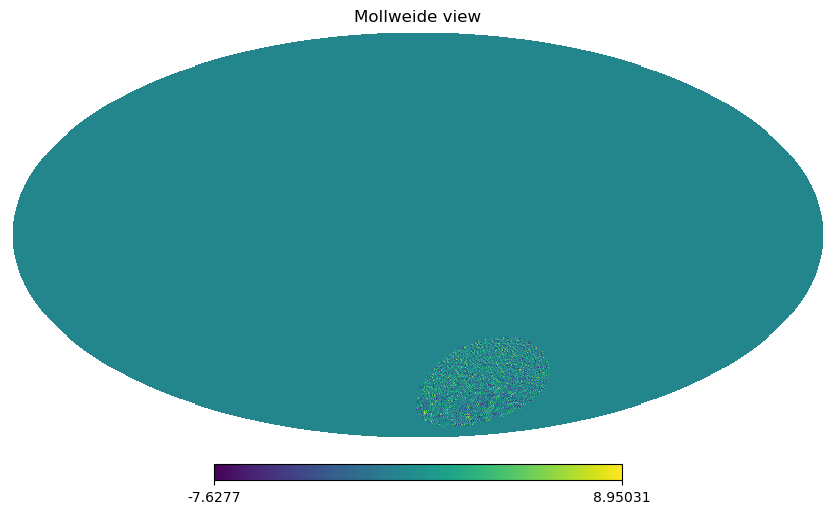

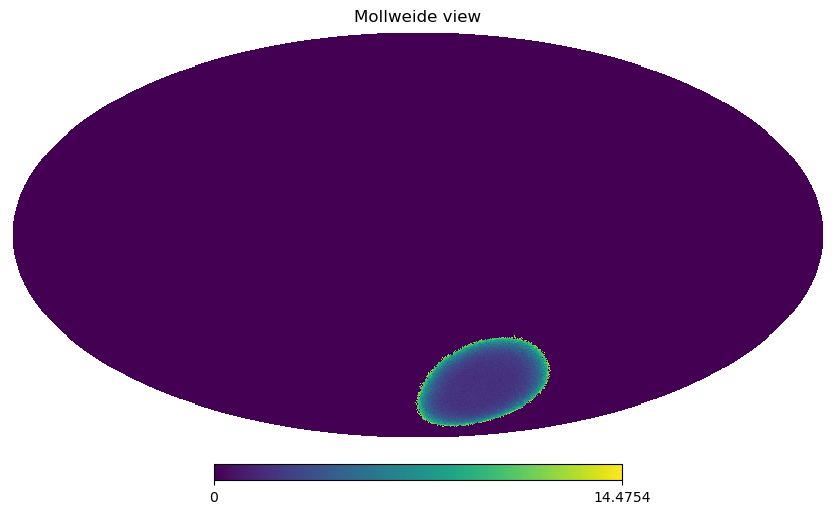

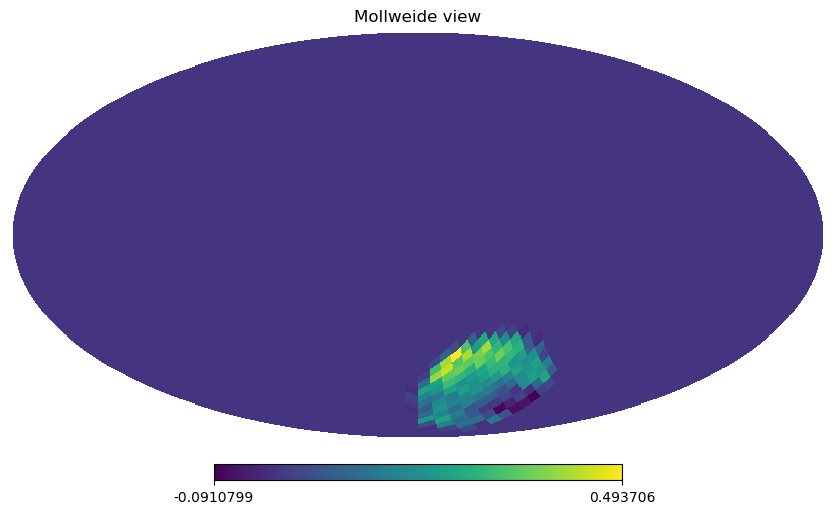

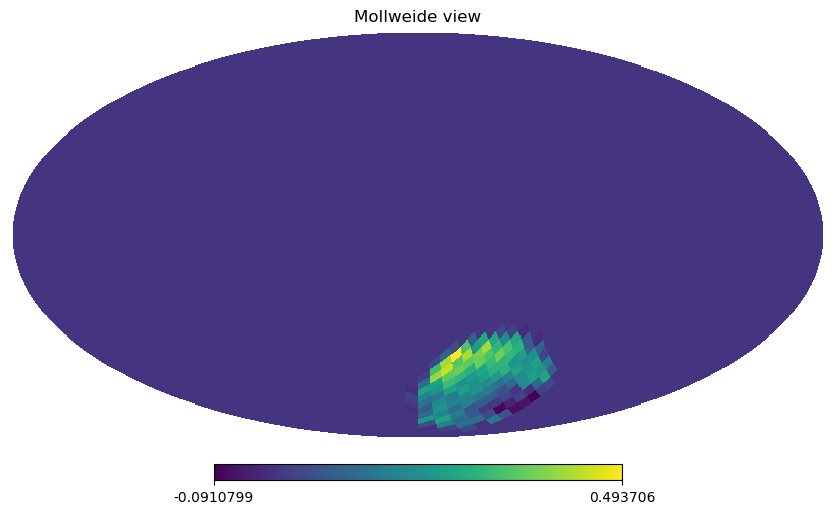

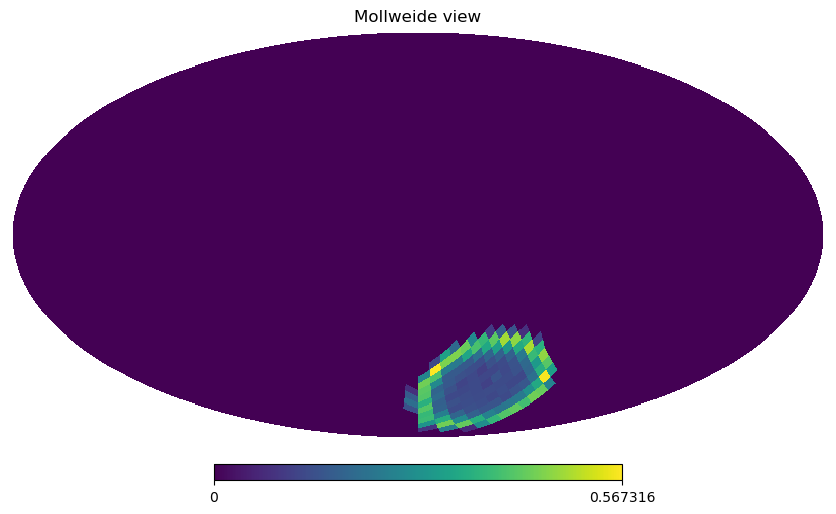

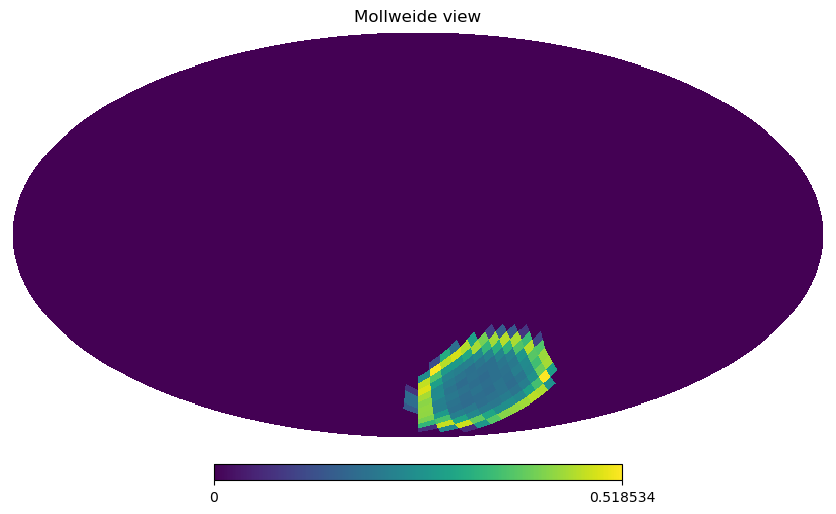

In [27]:
npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0))

nside_out = 16
npix_out = hp.nside2npix(nside_out)
ang_resolution = hp.nside2resol(nside_out, arcmin=True) / 60 # in deg
ratio_pixin_pixout = npix // npix_out

print(f'{ang_resolution} deg')
print(ratio_pixin_pixout)

avg_type = 'std'
dispersion = False

res_dg = hp.pixelfunc.ud_grade(masked_res, nside_out)
res_mean_dg = hp.pixelfunc.ud_grade(masked_mean_res, nside_out)
res_rms_dg = hp.pixelfunc.ud_grade(masked_res, nside_out, avg_type=avg_type, dispersion=dispersion)

hp.mollview(np.mean(res_dg,axis=0))
hp.mollview(res_mean_dg)

hp.mollview(np.std(res_dg,axis=0))
hp.mollview(np.mean(res_rms_dg,axis=0))


(99, 130)


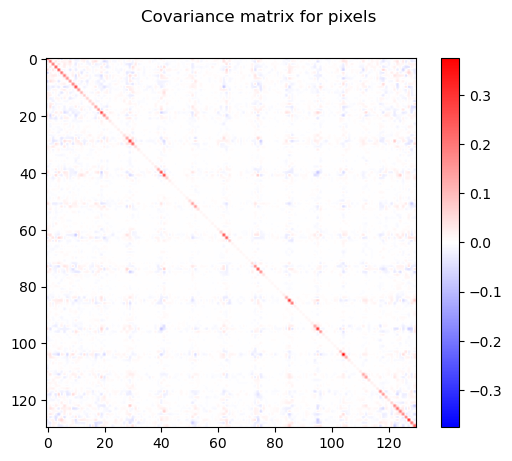

In [10]:
mask_dg = hp.pixelfunc.ud_grade(mask, nside_out)
seenpix_dg = np.array(mask_dg,dtype=bool)

res_dg_qubic = res_dg[:,seenpix_dg]
print(np.shape(res_dg_qubic))

cov = np.cov( res_dg_qubic, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for pixels')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [19]:
cov = np.cov( res_dg, rowvar = False )
cov = cov[seenpix_dg,:]
cov = cov[:,seenpix_dg]
print(np.shape(cov))

(130, 130)


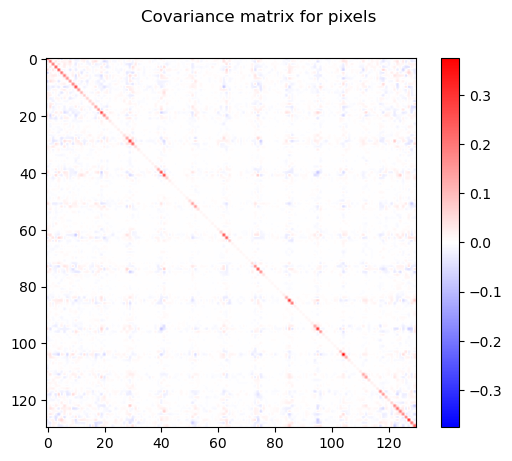

In [20]:
plt.figure()
plt.suptitle('Covariance matrix for pixels')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [26]:
8.29655/np.sqrt(256)

0.518534375

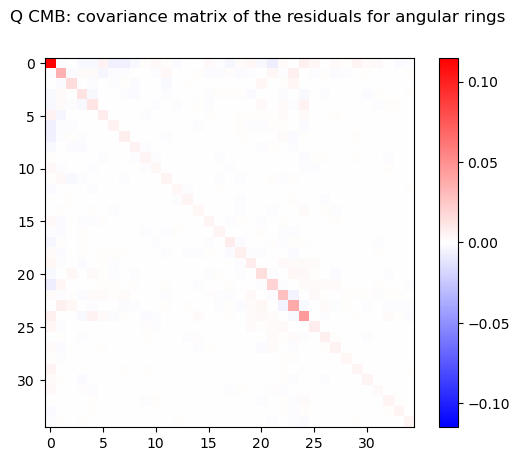

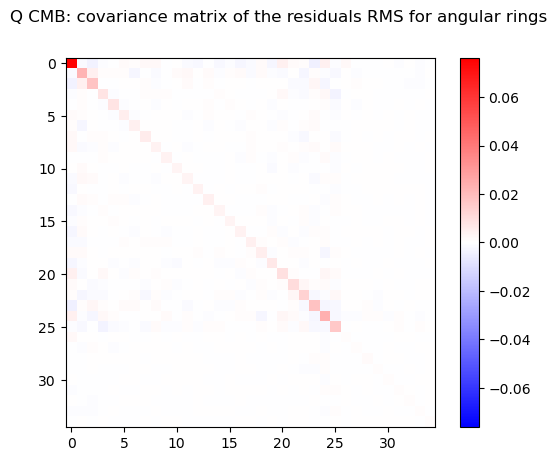

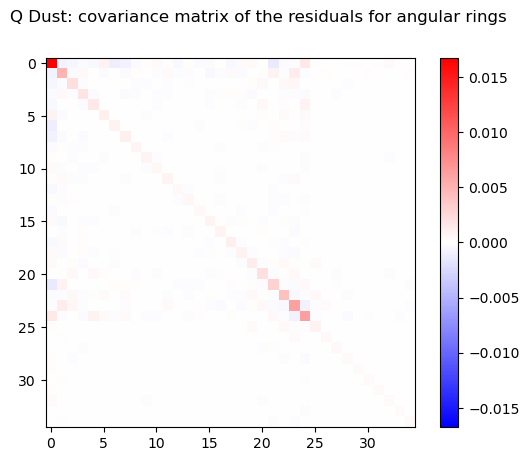

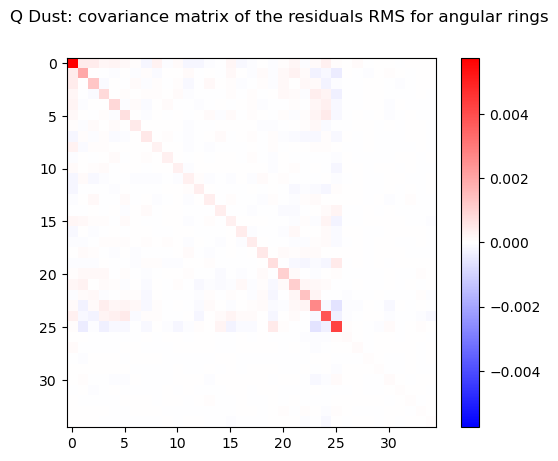

In [14]:
cov = np.cov( Q_cmb, rowvar = False )
plt.figure()
plt.suptitle('Q CMB: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_cmb, rowvar = False )
plt.figure()
plt.suptitle('Q CMB: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( Q_dust, rowvar = False )
plt.figure()
plt.suptitle('Q Dust: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_dust, rowvar = False )
plt.figure()
plt.suptitle('Q Dust: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

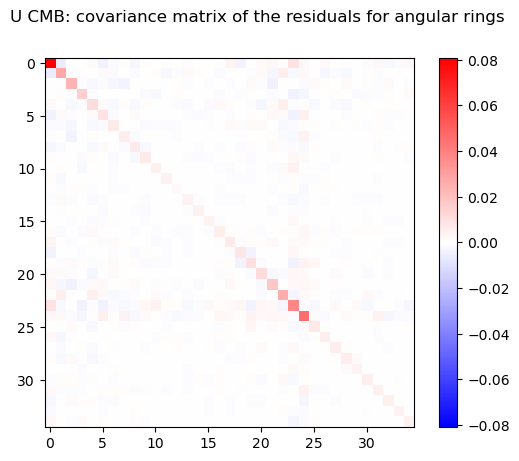

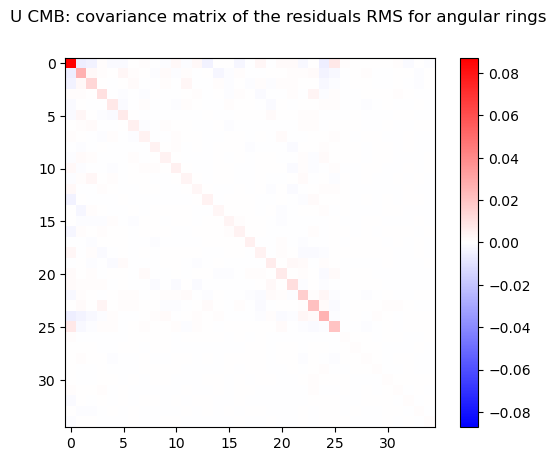

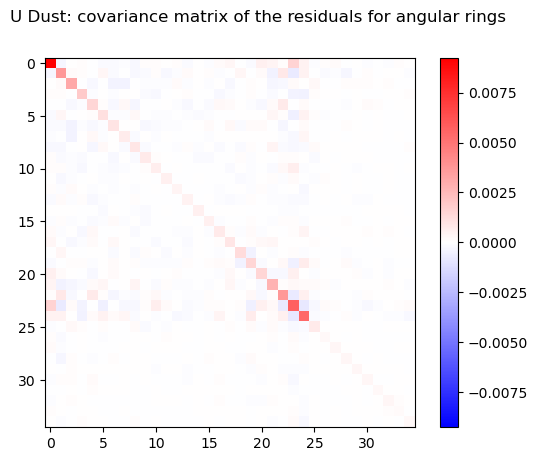

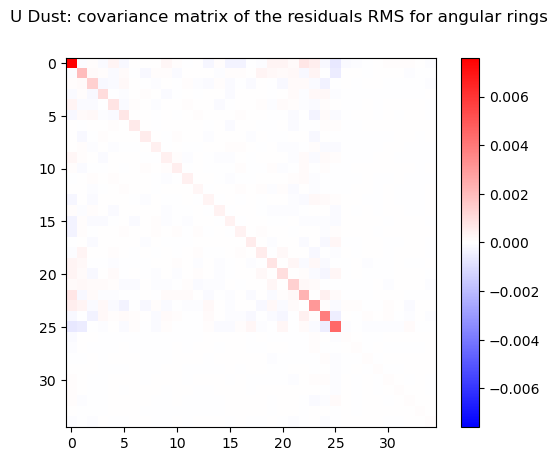

In [15]:
cov = np.cov( U_cmb, rowvar = False )
plt.figure()
plt.suptitle('U CMB: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_cmb, rowvar = False )
plt.figure()
plt.suptitle('U CMB: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( U_dust, rowvar = False )
plt.figure()
plt.suptitle('U Dust: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_dust, rowvar = False )
plt.figure()
plt.suptitle('U Dust: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

Text(0, 0.5, 'Residuals RMS value')

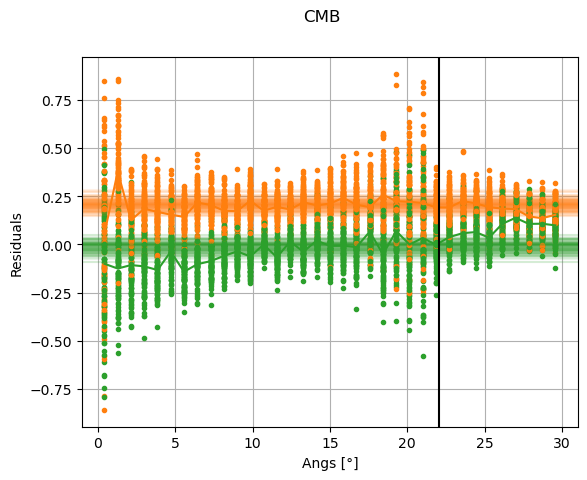

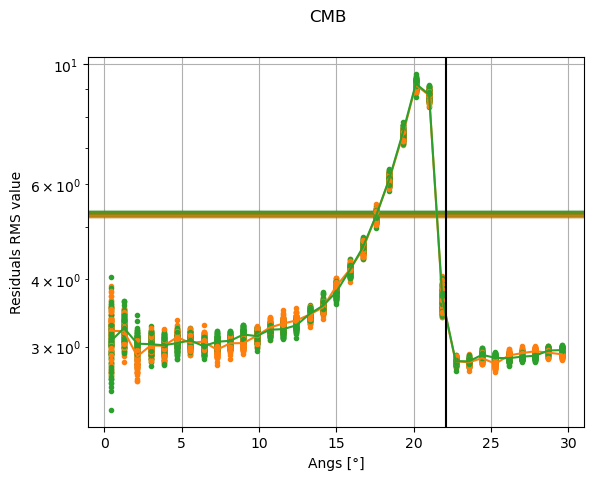

In [26]:
plt.figure()
for i in range(len(angs_cmb[:,0])):
    # plt.plot(angs_cmb[i,:],dI_cmb[i,:],'.',c='C0')
    plt.plot(angs_cmb[i,:],Q_cmb[i,:],'.',c='C1')
    plt.plot(angs_cmb[i,:],U_cmb[i,:],'.',c='C2')
    plt.axhline(Q_cmb_int[i],c='C1', alpha = 0.1)
    plt.axhline(U_cmb_int[i],c='C2', alpha = 0.1)
# plt.plot(angs_cmb[0,:],np.mean(dI_cmb,axis=0),c='C0')
plt.plot(angs_cmb[0,:],np.mean(Q_cmb,axis=0),c='C1')
plt.plot(angs_cmb[0,:],np.mean(U_cmb,axis=0),c='C2')
plt.axvline(angmax,c='k')
# plt.yscale('log')
plt.suptitle('CMB')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('Residuals')

plt.figure()
for i in range(len(angs_cmb[:,0])):
    # plt.plot(angs_cmb[i,:],dI_cmb[i,:],'.',c='C0')
    plt.plot(angs_cmb[i,:],dQ_cmb[i,:],'.',c='C1')
    plt.plot(angs_cmb[i,:],dU_cmb[i,:],'.',c='C2')
    plt.axhline(dQ_cmb_int[i],c='C1', alpha = 0.1)
    plt.axhline(dU_cmb_int[i],c='C2', alpha = 0.1)
# plt.plot(angs_cmb[0,:],np.mean(dI_cmb,axis=0),c='C0')
plt.plot(angs_cmb[0,:],np.mean(dQ_cmb,axis=0),c='C1')
plt.plot(angs_cmb[0,:],np.mean(dU_cmb,axis=0),c='C2')
plt.axvline(angmax,c='k')
plt.yscale('log')
plt.suptitle('CMB')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('Residuals RMS value')

Text(0, 0.5, 'Residuals RMS value')

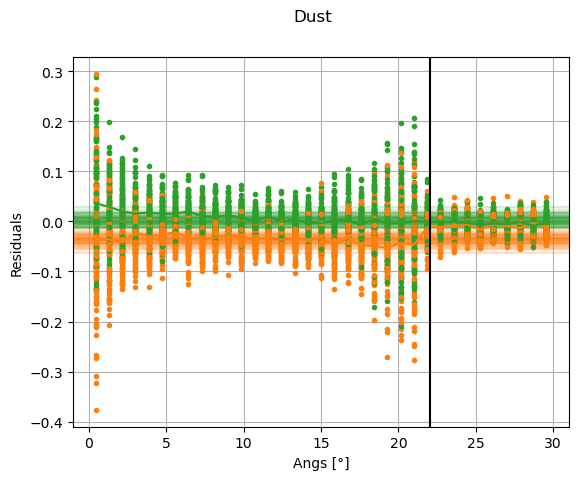

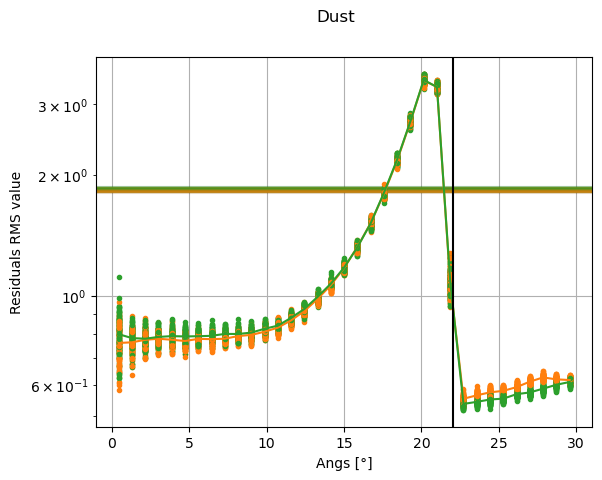

In [27]:
plt.figure()
for i in range(len(angs_cmb[:,0])):
    # plt.plot(angs_dust[i,:],dI_dust[i,:],'.',c='C0')
    plt.plot(angs_dust[i,:],Q_dust[i,:],'.',c='C1')
    plt.plot(angs_dust[i,:],U_dust[i,:],'.',c='C2')
    plt.axhline(Q_dust_int[i],c='C1', alpha = 0.1)
    plt.axhline(U_dust_int[i],c='C2', alpha = 0.1)
# plt.plot(angs_dust[0,:],np.mean(dI_dust,axis=0),c='C0')
plt.plot(angs_dust[0,:],np.mean(Q_dust,axis=0),c='C1')
plt.plot(angs_dust[0,:],np.mean(U_dust,axis=0),c='C2')
plt.axvline(angmax,c='k')
# plt.yscale('log')
plt.suptitle('Dust')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('Residuals')

plt.figure()
for i in range(len(angs_cmb[:,0])):
    # plt.plot(angs_dust[i,:],dI_dust[i,:],'.',c='C0')
    plt.plot(angs_dust[i,:],dQ_dust[i,:],'.',c='C1')
    plt.plot(angs_dust[i,:],dU_dust[i,:],'.',c='C2')
    plt.axhline(dQ_dust_int[i],c='C1', alpha = 0.1)
    plt.axhline(dU_dust_int[i],c='C2', alpha = 0.1)
# plt.plot(angs_dust[0,:],np.mean(dI_dust,axis=0),c='C0')
plt.plot(angs_dust[0,:],np.mean(dQ_dust,axis=0),c='C1')
plt.plot(angs_dust[0,:],np.mean(dU_dust,axis=0),c='C2')
plt.axvline(angmax,c='k')
plt.yscale('log')
plt.suptitle('Dust')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('Residuals RMS value')

In [191]:
results = {}
results['angs_cmb'] = angs_cmb
results['dQ_cmb'] = dQ_cmb
results['dU_cmb'] = dU_cmb
results['angs_dust'] = angs_dust
results['dQ_dust'] = dQ_dust
results['dU_dust'] = dU_dust
results['dQ_cmb_int'] = dQ_cmb_int
results['dU_cmb_int']= dU_cmb_int
results['dQ_dust_int'] = dQ_dust_int
results['dU_dust_int'] = dU_dust_int 
results['angmax'] = angmax

In [192]:
# np.save('noise_304470',results)
# np.save('noise_100143_0_48',results)
# np.save('noise_100143_48_99',results)
# np.save('noise_217353',results)
np.save('noise_fullHFI',results)

In [235]:
results_dict = np.load('noise_304470.npy',allow_pickle=True).item()
# results_dict = np.load('noise_100143_0_48.npy',allow_pickle=True).item()
# results_dict = np.load('noise_100143_48_99.npy',allow_pickle=True).item()
# results_dict = np.load('noise_217353.npy',allow_pickle=True).item()
# results_dict = np.load('noise_fullHFI.npy',allow_pickle=True).item()

# print(results_dict.keys())

angs_cmb = results_dict['angs_cmb'] 
dQ_cmb = results_dict['dQ_cmb'] 
dU_cmb = results_dict['dU_cmb'] 
angs_dust = results_dict['angs_dust'] 
dQ_dust = results_dict['dQ_dust'] 
dU_dust = results_dict['dU_dust'] 
dQ_cmb_int = results_dict['dQ_cmb_int'] 
dU_cmb_int = results_dict['dU_cmb_int']
dQ_dust_int = results_dict['dQ_dust_int'] 
dU_dust_int = results_dict['dU_dust_int'] 
angmax = results_dict['angmax']

In [236]:
# results_dict = np.load('noise_304470.npy',allow_pickle=True).item()
# results_dict = np.load('noise_100143_0_48.npy',allow_pickle=True).item()
# results_dict = np.load('noise_100143_48_99.npy',allow_pickle=True).item()
# results_dict = np.load('noise_217353.npy',allow_pickle=True).item()
results_dict = np.load('noise_fullHFI.npy',allow_pickle=True).item()

# print(results_dict.keys())

angs_cmb_1 = results_dict['angs_cmb'] 
dQ_cmb_1 = results_dict['dQ_cmb'] 
dU_cmb_1 = results_dict['dU_cmb'] 
angs_dust_1 = results_dict['angs_dust'] 
dQ_dust_1 = results_dict['dQ_dust'] 
dU_dust_1 = results_dict['dU_dust'] 
dQ_cmb_int_1 = results_dict['dQ_cmb_int'] 
dU_cmb_int_1 = results_dict['dU_cmb_int']
dQ_dust_int_1 = results_dict['dQ_dust_int'] 
dU_dust_int_1 = results_dict['dU_dust_int'] 
angmax_1 = results_dict['angmax']



Text(0, 0.5, 'RMS noise')

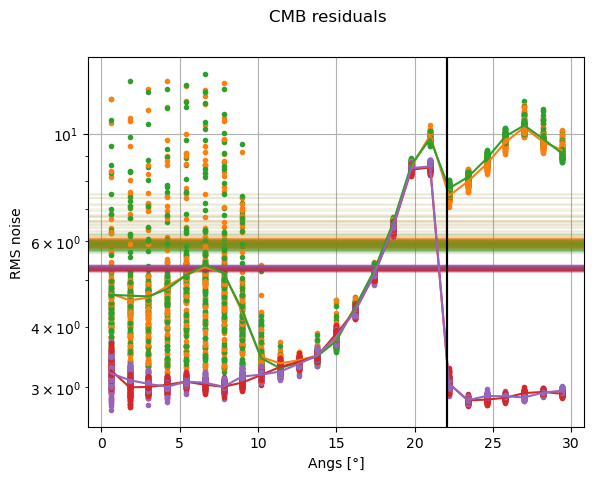

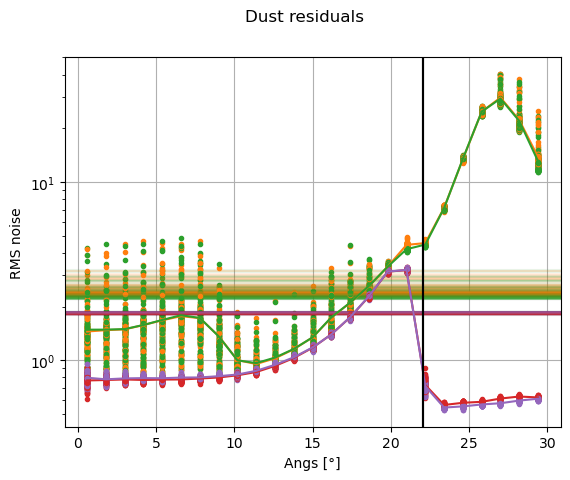

In [237]:
plt.figure()
for i in range(len(angs_cmb[:,0])):
    # plt.plot(angs_cmb[i,:],dI_cmb[i,:],'.',c='C0')
    plt.semilogy(angs_cmb[i,:],dQ_cmb[i,:],'.',c='C1')
    plt.semilogy(angs_cmb[i,:],dU_cmb[i,:],'.',c='C2')
    plt.axhline(dQ_cmb_int[i],c='C1', alpha = 0.1)
    plt.axhline(dU_cmb_int[i],c='C2', alpha = 0.1)
for i in range(len(angs_cmb_1[:,0])):
    plt.semilogy(angs_cmb_1[i,:],dQ_cmb_1[i,:],'.',c='C3')
    plt.semilogy(angs_cmb_1[i,:],dU_cmb_1[i,:],'.',c='C4')
    plt.axhline(dQ_cmb_int_1[i],c='C3', alpha = 0.1)
    plt.axhline(dU_cmb_int_1[i],c='C4', alpha = 0.1)
# plt.plot(angs_cmb[0,:],np.mean(dI_cmb,axis=0),c='C0')
plt.semilogy(angs_cmb[0,:],np.mean(dQ_cmb,axis=0),c='C1')
plt.semilogy(angs_cmb[0,:],np.mean(dU_cmb,axis=0),c='C2')
plt.semilogy(angs_cmb_1[0,:],np.mean(dQ_cmb_1,axis=0),c='C3')
plt.semilogy(angs_cmb_1[0,:],np.mean(dU_cmb_1,axis=0),c='C4')
plt.axvline(angmax,c='k')
plt.axvline(angmax_1,c='k')
plt.suptitle('CMB residuals')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise')

plt.figure()
for i in range(len(angs_cmb[:,0])):
    # plt.plot(angs_dust[i,:],dI_dust[i,:],'.',c='C0')
    plt.semilogy(angs_dust[i,:],dQ_dust[i,:],'.',c='C1')
    plt.semilogy(angs_dust[i,:],dU_dust[i,:],'.',c='C2')
    plt.axhline(dQ_dust_int[i],c='C1', alpha = 0.1)
    plt.axhline(dU_dust_int[i],c='C2', alpha = 0.1)
for i in range(len(angs_cmb_1[:,0])):
    plt.semilogy(angs_dust_1[i,:],dQ_dust_1[i,:],'.',c='C3')
    plt.semilogy(angs_dust_1[i,:],dU_dust_1[i,:],'.',c='C4')
    plt.axhline(dQ_dust_int_1[i],c='C3', alpha = 0.1)
    plt.axhline(dU_dust_int_1[i],c='C4', alpha = 0.1)
# plt.plot(angs_dust[0,:],np.mean(dI_dust,axis=0),c='C0')
plt.semilogy(angs_dust[0,:],np.mean(dQ_dust,axis=0),c='C1')
plt.semilogy(angs_dust[0,:],np.mean(dU_dust,axis=0),c='C2')
plt.semilogy(angs_dust_1[0,:],np.mean(dQ_dust_1,axis=0),c='C3')
plt.semilogy(angs_dust_1[0,:],np.mean(dU_dust_1,axis=0),c='C4')
plt.axvline(angmax,c='k')
plt.axvline(angmax_1,c='k')
plt.suptitle('Dust residuals')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise')

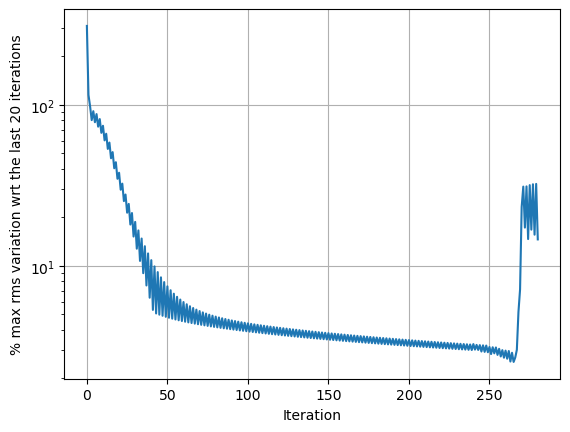

In [238]:
rms_vs_iter_304470 = np.loadtxt('rms_vs_iter_304470.txt')
plt.figure()
plt.semilogy(rms_vs_iter_304470*100)
plt.ylabel('% max rms variation wrt the last 20 iterations')
plt.xlabel('Iteration')
plt.grid()

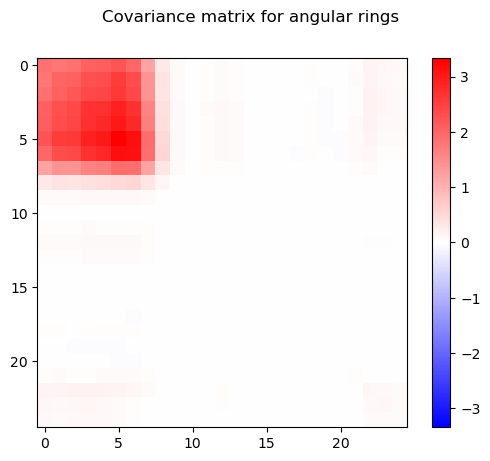

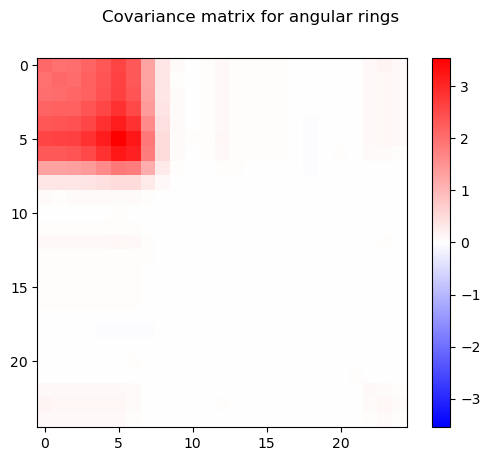

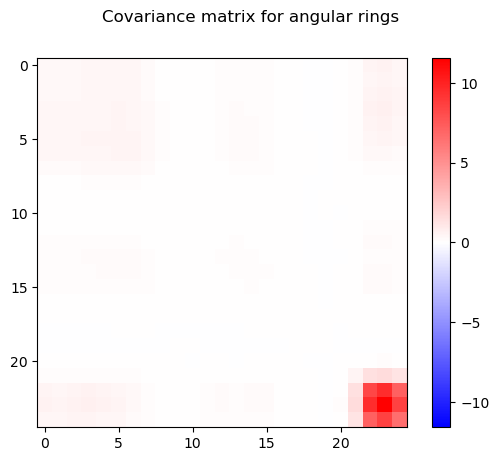

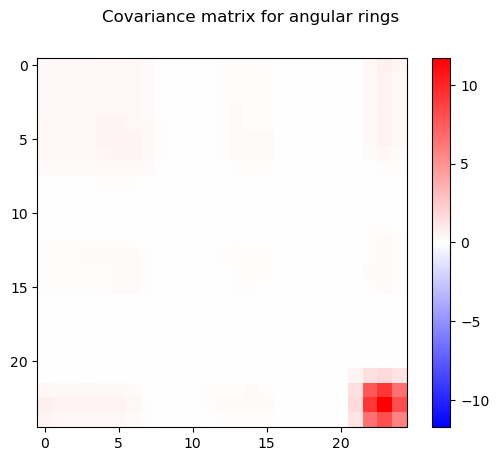

In [244]:
cov = np.cov( dQ_cmb, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_cmb, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_dust, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_dust, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

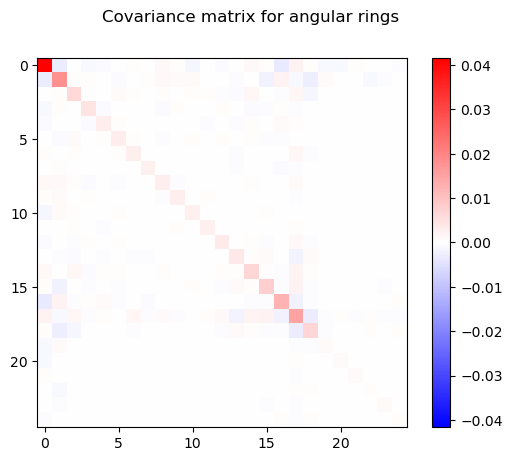

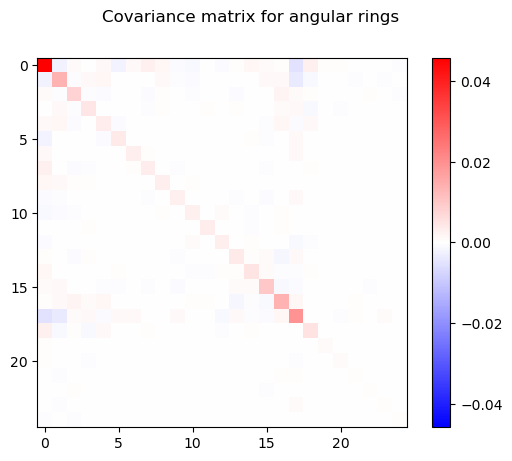

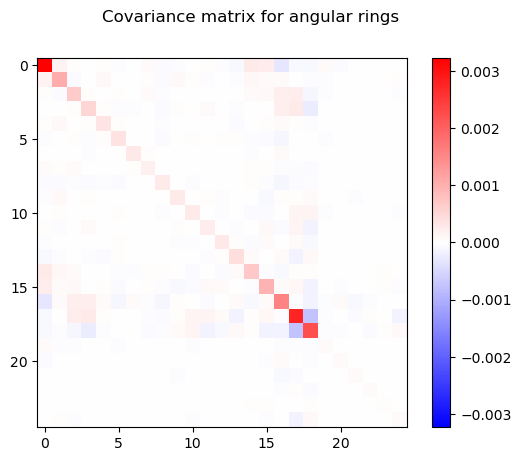

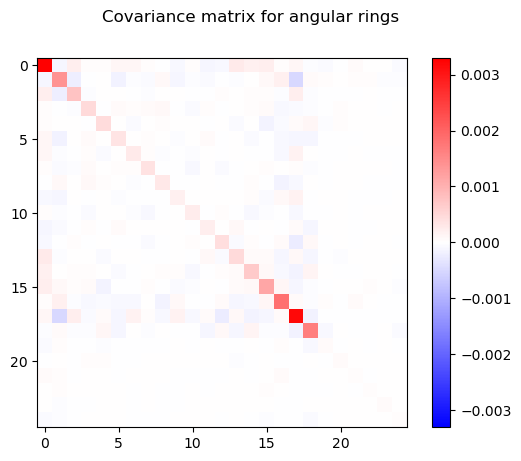

In [243]:
cov = np.cov( dQ_cmb_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_cmb_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_dust_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_dust_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()